# Prepare dataset

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import string

possible_categories = [letter.lower() for i, letter in enumerate(string.ascii_uppercase) if letter not in ['J', 'Z']]
#possible_categories.append("*") # unknown symbol
#possible_categories.extend([str(x) for x in range(0, 10)]) # digits 0-9

possible_categories.remove("r") # Remove "r" as the quality in the converted dataset wasn't sufficient

def load_dataset_from_csv(path, keep_every=1):
    df = pd.read_csv(path, dtype={63: str}, header=None)
    df = df[df[63].notna() & df[63].apply(lambda l: str(l).lower()).isin(possible_categories)]
    if keep_every > 1:
        df = df[df.index % keep_every == 0]
    df[63] = df[63].apply(lambda l: l.lower())
    return df

In [3]:
# Load own dataset
my_dataset = load_dataset_from_csv("my_dataset.csv")

# Load mnist (converted)
mnist_df = load_dataset_from_csv("mnist_dataset.csv")
mnist_df = mnist_df[mnist_df[63] != "r"] # Need to remove r as it is mainly faulty

# Load exter (converted)
exter_df = pd.DataFrame()
for p in ["A", "B", "C", "D", "E"]:
    exported_df = load_dataset_from_csv(f"exter_{p}.csv")
    exter_df = pd.concat([exter_df, exported_df])
exter_df = exter_df[exter_df[63] != "r"] # Need to remove r as it is mainly faulty

In [4]:
def category_distrib(df, title=""):
    category_counts = df[63].value_counts()
    plt.figure(figsize=(8, 6))
    category_counts.plot(kind='bar')
    plt.xlabel('Kategóriák', fontname="Calibri")
    plt.ylabel('Minták száma', fontname="Calibri")
    plt.title(title, fontname="Calibri")
    #plt.savefig('Distribution of training dataset Categories.png', dpi=300)  # High resolution
    plt.show()

def equalize_category_counts(df, category_column, max_size=None):
    # Group by category and find the maximum size
    if not max_size:
        max_size = df.groupby(category_column).size().min()

    # Resample each group
    resampled = [group.sample(max_size, replace=True) for _, group in df.groupby(category_column)]

    # Concatenate the resampled groups
    return pd.concat(resampled, ignore_index=True)

In [5]:
from sklearn.model_selection import train_test_split

# Assuming train_df contains the landmarks in order
# A better way to separate train-valid split is to take the last x% of the data. If it's done randomly with shuffling similar datapoints may appear in the validation data.

# category_distrib(train_df, "train")
train_df = pd.concat([exter_df, mnist_df])
train_df = equalize_category_counts(train_df, 63)
# category_distrib(train_df, "train equalized")
test_df = my_dataset
# category_distrib(test_df, "test")

# Find unique categories
categories = train_df[63].unique()

train_list = []
valid_list = []
for category in categories:
    category_data = train_df[train_df[63] == category]
    # 80-20% split, shuffle must be False
    train_category, val_category = train_test_split(category_data, test_size=0.2, shuffle=False)
    train_list.append(train_category)
    valid_list.append(val_category)

train_df = pd.concat(train_list).reset_index(drop=True)
val_df = pd.concat(valid_list).reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [6]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.443624,0.609685,-0.000002,0.285040,0.566032,-0.049490,0.151672,0.437411,-0.073124,0.093853,...,0.504989,0.260679,-0.146470,0.481291,0.359016,-0.106028,0.492501,0.391604,-0.064769,a
1,0.557635,0.666392,-0.000002,0.356236,0.603243,-0.044109,0.225389,0.449338,-0.058051,0.179375,...,0.654005,0.259604,-0.115895,0.618957,0.360273,-0.064983,0.643777,0.397425,-0.009690,a
2,0.541870,0.548811,-0.000002,0.368016,0.512834,-0.052881,0.211015,0.385724,-0.078186,0.142968,...,0.584162,0.194180,-0.119834,0.573830,0.297180,-0.080093,0.606240,0.307644,-0.038489,a
3,0.489768,0.600019,-0.000002,0.343733,0.560331,-0.037838,0.212566,0.436968,-0.059582,0.135788,...,0.496589,0.251614,-0.150918,0.477483,0.360986,-0.111674,0.511333,0.392593,-0.067708,a
4,0.451567,0.576961,-0.000002,0.321057,0.571127,-0.077153,0.195126,0.464831,-0.114361,0.153030,...,0.532120,0.286913,-0.204000,0.523829,0.397878,-0.160859,0.542804,0.413135,-0.114783,a


In [7]:
from tqdm import tqdm

def move_hand_lms_to_middle(flat_xyz: np.ndarray):
    if len(flat_xyz.shape) == 1:
        flat_xyz = np.array([flat_xyz])

    batch_dim = flat_xyz.shape[0]

    # Reshape flat data to [num_samples, 21, 3]
    xyz = flat_xyz.reshape((batch_dim, 21, 3))
    xy = xyz[:, :, :2]

    # Compute the translation required to move the center of the bounding box to (0.5, 0.5)
    min_coords = np.min(xy, axis=1)
    max_coords = np.max(xy, axis=1)
    scaled_centers = (min_coords + max_coords) / 2
    translations = np.array([[0.5, 0.5]] * batch_dim) - scaled_centers

    translated_xy = xy + translations[:, np.newaxis, :]

    # Stitch back to original shape
    xyz = np.concatenate([translated_xy, xyz[:, :, 2:]], axis=2)
    return xyz.reshape((batch_dim, -1))

def _scale_hand_lms(flat_xyz, target_size=0.55):
    # Reshape flat data to [num_samples, 3]
    xyz = flat_xyz.reshape((21, 3)) # 21 coords for the hands

    # Take only the x and y coordinates
    xy = xyz[:, :2]

    # Create a mask to ignore rows with NaN values
    mask = ~np.isnan(xy).any(axis=1)
    valid_landmarks = xy[mask]
    min_coords = np.min(valid_landmarks, axis=0)
    max_coords = np.max(valid_landmarks, axis=0)

    # Compute the scale factor
    width = max_coords[0] - min_coords[0]
    height = max_coords[1] - min_coords[1]
    scale_factor = target_size / max(width, height)

    # Apply the scaling
    scaled_xy = xy * scale_factor

    xyz = np.stack([scaled_xy[:, 0], scaled_xy[:, 1], xyz[:, 2]], axis=1)
    flat_xyz = np.reshape(xyz, [-1])

    return move_hand_lms_to_middle(flat_xyz)

def scale_hand_lms(flat_xyz: np.ndarray, target_size=0.55) -> np.ndarray:
    if len(flat_xyz.shape) == 1:
        flat_xyz = np.array([flat_xyz])

    batch_dim = flat_xyz.shape[0]

    # Reshape flat data to [num_samples, 21, 3]
    xyz = flat_xyz.reshape((batch_dim, 21, 3))

    # Take only the x and y coordinates
    xy = xyz[:, :, :2]

    # Replace NaN values with np.inf for min calculation and -np.inf for max calculation
    min_coords = np.nanmin(np.where(np.isnan(xy), np.inf, xy), axis=1)
    max_coords = np.nanmax(np.where(np.isnan(xy), -np.inf, xy), axis=1)

    # Compute the scale factor
    width = max_coords[:, 0] - min_coords[:, 0]
    height = max_coords[:, 1] - min_coords[:, 1]
    scale_factor = target_size / np.maximum(width, height)

    # Apply the scaling
    scaled_xy = xy * scale_factor[:, np.newaxis, np.newaxis]

    # Stitch back to original shape
    xyz = np.concatenate([scaled_xy, xyz[:, :, 2:]], axis=2)
    flat_xyz = xyz.reshape((batch_dim, -1))

    return move_hand_lms_to_middle(flat_xyz)

def nan_mean(x, axis=0, keepdims=False):
    """Function to calculate mean ignoring NaN values"""
    sum_x = np.nansum(x, axis=axis, keepdims=keepdims)
    count_x = np.sum(~np.isnan(x), axis=axis, keepdims=keepdims)
    return sum_x / count_x

def nan_std(x, axis=0, keepdims=False):
    """Function to calculate standard deviation ignoring NaN values"""
    center = nan_mean(x, axis=axis, keepdims=True)
    d = x - center
    return np.sqrt(nan_mean(d * d, axis=axis, keepdims=keepdims))

def preprocess_lms(lms: np.ndarray) -> np.ndarray:
    if len(lms.shape) == 1:
        lms = np.array([lms])
    lms = scale_hand_lms(lms)
    mean = nan_mean(lms, axis=1)
    std = nan_std(lms, axis=1)
    lms = (lms-mean[:, np.newaxis]) / std[:, np.newaxis]
    return np.where(np.isnan(lms), 0., lms)

def processed_lms(df: pd.DataFrame) -> pd.DataFrame:
    lms = df.values[:, :-1].astype(np.float32)
    processed_lms = preprocess_lms(lms)
    preprocessed_df = pd.DataFrame(processed_lms)
    preprocessed_df[63] = df.values[:, -1]
    return preprocessed_df

In [8]:
# train_df = processed_lms(train_df)
# val_df = processed_lms(val_df)
# test_df = processed_lms(test_df)

In [9]:
import torch
from typing import List
from torch_geometric.data import Data, InMemoryDataset
import numpy as np
from sklearn.preprocessing import LabelEncoder

class GraphDataset(InMemoryDataset):
    def __init__(self, df: pd.DataFrame, transform=None, pre_transform=None):
        self.label_encoder = LabelEncoder()
        self.connections = [(0,1), (0,5), (0,17), (1,2), (2,3), (3,4),
                            (5,6), (5,9), (6,7), (7,8), (9,10), (9,13), 
                            (10,11), (11,12), (13,14), (13,17), (14,15), 
                            (15,16), (17,18), (18,19), (19,20)]

        super().__init__(None, transform, pre_transform)
        self.data_list = self.process_data(df)

    def process_data(self, df: pd.DataFrame) -> List[Data]:
        # Encode the categorical column
        labels = self.label_encoder.fit_transform(df.iloc[:, -1])
        features = preprocess_lms(df.values[:, :-1].astype(np.float32)).reshape((len(df), 21,3))

        # Create the edge list and make it undirected by adding reverse connections (same for all graphs)
        edges = []
        for a, b in self.connections:
            edges.append([a, b])
            edges.append([b, a])  # Add the reverse connection
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

        data_list = []
        for feature, label in zip(features, labels):
            # Create the graph data object
            x = torch.tensor(feature, dtype=torch.float)
            y = torch.tensor(label, dtype=torch.long)
            data = Data(x=x, edge_index=edge_index, y=y)
            data_list.append(data)

        return data_list
    
    @property
    def num_classes(self):
        return len(set(self.label_encoder.classes_))

    @property
    def num_node_features(self):
        return 3

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

In [10]:
train_df = load_dataset_from_csv("train_ds.csv").sample(frac=1, random_state=42, ignore_index=True)
val_df = load_dataset_from_csv("valid_ds.csv").sample(frac=1, random_state=42, ignore_index=True)
test_df = load_dataset_from_csv("test_ds.csv").sample(frac=1, random_state=42, ignore_index=True)

In [11]:
train_dataset = GraphDataset(train_df)
val_dataset = GraphDataset(val_df)
test_dataset = GraphDataset(test_df)

print(f'Dataset: {train_dataset}:')
print('====================')
print(f'Number of graphs: {len(train_dataset)}')
print(f'Number of features: {train_dataset.num_features}')
print(f'Number of classes: {train_dataset.num_classes}')

data = train_dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: GraphDataset(30843):
Number of graphs: 30843
Number of features: 3
Number of classes: 23

Data(x=[21, 3], edge_index=[2, 42], y=7)
Number of nodes: 21
Number of edges: 42
Average node degree: 2.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


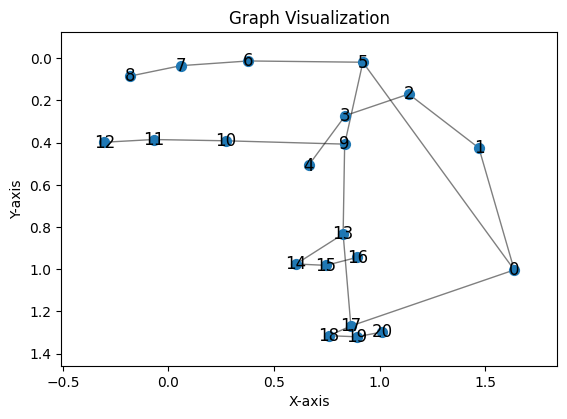

In [12]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_graph(data):
    node_features = data.x.numpy()
    edge_index = data.edge_index.numpy()
    
    x = node_features[:, 0]
    y = node_features[:, 1]

    G = nx.Graph()
    G.add_edges_from(edge_index.T)

    pos = {i: (x[i], y[i]) for i in range(len(x))}

    # Create figure and axis
    fig, ax = plt.subplots()

    # Plot the graph on the given axis
    nx.draw_networkx_nodes(G, pos, node_size=50, ax=ax)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=12, ax=ax)

    # Invert the y-axis and set equal aspect ratio
    ax.invert_yaxis()
    ax.set_aspect('equal', adjustable='box')

    # Enable ticks on both axes
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

    # Add labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title("Graph Visualization")

    # Display the plot
    plt.show()

# Example usage
graph_data = train_dataset.get(0)
visualize_graph(graph_data)

In [13]:
from torch_geometric.loader import DataLoader

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for step, data in enumerate(train_loader):
    if step < 3:
        print(f'Step {step + 1}:')
        print('=======')
        print(f'Number of graphs in the current batch: {data.num_graphs}')
        print(data)
        print()
    else:
        break

Step 1:
Number of graphs in the current batch: 256
DataBatch(x=[5376, 3], edge_index=[2, 10752], y=[256], batch=[5376], ptr=[257])

Step 2:
Number of graphs in the current batch: 256
DataBatch(x=[5376, 3], edge_index=[2, 10752], y=[256], batch=[5376], ptr=[257])

Step 3:
Number of graphs in the current batch: 256
DataBatch(x=[5376, 3], edge_index=[2, 10752], y=[256], batch=[5376], ptr=[257])



In [18]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GATConv(train_dataset.num_node_features, hidden_channels, heads=1, concat=False)
        self.conv2 = GATConv(hidden_channels, hidden_channels, heads=1, concat=False)
        self.conv3 = GATConv(hidden_channels, hidden_channels, heads=1, concat=False)
        self.conv4 = GATConv(hidden_channels, 64, heads=1, concat=False)
        self.lin = Linear(64, train_dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        #x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=128)
print(model)

GCN(
  (conv1): GATConv(3, 128, heads=1)
  (conv2): GATConv(128, 128, heads=1)
  (conv3): GATConv(128, 128, heads=1)
  (conv4): GATConv(128, 64, heads=1)
  (lin): Linear(in_features=64, out_features=23, bias=True)
)


In [19]:
optimizer = torch.optim.Adam(model.parameters()) #, lr=0.01
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    for data in train_loader:
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def evaluate(loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

for epoch in range(1, 100):
    train()
    val_acc = evaluate(val_loader)
    test_acc = evaluate(test_loader)
    print(f'Epoch: {epoch:03d}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Val Acc: 0.1960, Test Acc: 0.1414
Epoch: 002, Val Acc: 0.4274, Test Acc: 0.1008
Epoch: 003, Val Acc: 0.5290, Test Acc: 0.0898
Epoch: 004, Val Acc: 0.6104, Test Acc: 0.1207
Epoch: 005, Val Acc: 0.6391, Test Acc: 0.1177
Epoch: 006, Val Acc: 0.6552, Test Acc: 0.1275
Epoch: 007, Val Acc: 0.6621, Test Acc: 0.1234
Epoch: 008, Val Acc: 0.6650, Test Acc: 0.1355
Epoch: 009, Val Acc: 0.6751, Test Acc: 0.1248
Epoch: 010, Val Acc: 0.6955, Test Acc: 0.1777
Epoch: 011, Val Acc: 0.6923, Test Acc: 0.1363
Epoch: 012, Val Acc: 0.7021, Test Acc: 0.1645
Epoch: 013, Val Acc: 0.7074, Test Acc: 0.1707
Epoch: 014, Val Acc: 0.7105, Test Acc: 0.1751
Epoch: 015, Val Acc: 0.7089, Test Acc: 0.1145
Epoch: 016, Val Acc: 0.7276, Test Acc: 0.1624
Epoch: 017, Val Acc: 0.7363, Test Acc: 0.1952
Epoch: 018, Val Acc: 0.7327, Test Acc: 0.1777
Epoch: 019, Val Acc: 0.7341, Test Acc: 0.1724
Epoch: 020, Val Acc: 0.7369, Test Acc: 0.1689
Epoch: 021, Val Acc: 0.7438, Test Acc: 0.1556
Epoch: 022, Val Acc: 0.7425, Test 

# Regular NN

In [10]:
train_df = load_dataset_from_csv("train_ds.csv").sample(frac=1, random_state=42, ignore_index=True)
val_df = load_dataset_from_csv("valid_ds.csv").sample(frac=1, random_state=42, ignore_index=True)
test_df = load_dataset_from_csv("test_ds.csv").sample(frac=1, random_state=42, ignore_index=True)

In [22]:
import torch
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader


class StaticASLFingerspellingDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        """
        Args:
            df (pd.DataFrame): DataFrame where the last column is the label.
        """
        processed_features = preprocess_lms(df.iloc[:, :-1].values.astype(np.float32))
        self.features = torch.tensor(processed_features, dtype=torch.float32)  # Convert features to tensors

        self.label_encoder = LabelEncoder()
        labels = self.label_encoder.fit_transform(df.iloc[:, -1])
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    
    @property
    def num_classes(self):
        return len(set(self.label_encoder.classes_))

In [23]:
batch_size = 256
nn_train_loader = DataLoader(StaticASLFingerspellingDataset(train_df), batch_size=batch_size, shuffle=True)
nn_valid_loader = DataLoader(StaticASLFingerspellingDataset(val_df), batch_size=batch_size, shuffle=True)
nn_test_loader = DataLoader(StaticASLFingerspellingDataset(test_df), batch_size=batch_size, shuffle=True)

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate=0.05):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(128, 16)
        self.fc4 = nn.Linear(16, output_dim)

    def forward(self, x):
        x = F.silu(self.fc1(x))  # swish activation
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.silu(self.fc3(x))  # swish activation
        x = F.softmax(self.fc4(x), dim=1)
        return x

model = MLP(input_dim=63, output_dim=nn_train_loader.dataset.num_classes)
print(model)

MLP(
  (fc1): Linear(in_features=63, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout(p=0.05, inplace=False)
  (fc3): Linear(in_features=128, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=23, bias=True)
)


In [28]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    for x, y in nn_train_loader:
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def evaluate(loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in loader:
            out = model(x)
            pred = out.argmax(dim=1)
            correct += int((pred == y).sum())
    return correct / len(loader.dataset)

for epoch in range(1, 100):
    train()
    val_acc = evaluate(nn_valid_loader)
    test_acc = evaluate(nn_test_loader)
    print(f'Epoch: {epoch:03d}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Val Acc: 0.4124, Test Acc: 0.2872
Epoch: 002, Val Acc: 0.5371, Test Acc: 0.4549
Epoch: 003, Val Acc: 0.5503, Test Acc: 0.5184
Epoch: 004, Val Acc: 0.5635, Test Acc: 0.4966
Epoch: 005, Val Acc: 0.5637, Test Acc: 0.5316
Epoch: 006, Val Acc: 0.5774, Test Acc: 0.5250
Epoch: 007, Val Acc: 0.5810, Test Acc: 0.5245
Epoch: 008, Val Acc: 0.5884, Test Acc: 0.5272
Epoch: 009, Val Acc: 0.5867, Test Acc: 0.5393
Epoch: 010, Val Acc: 0.5905, Test Acc: 0.5349
Epoch: 011, Val Acc: 0.5911, Test Acc: 0.5407
Epoch: 012, Val Acc: 0.5980, Test Acc: 0.5479
Epoch: 013, Val Acc: 0.5952, Test Acc: 0.5022
Epoch: 014, Val Acc: 0.6060, Test Acc: 0.5310
Epoch: 015, Val Acc: 0.5999, Test Acc: 0.5310
Epoch: 016, Val Acc: 0.5832, Test Acc: 0.5342
Epoch: 017, Val Acc: 0.6109, Test Acc: 0.5349
Epoch: 018, Val Acc: 0.6071, Test Acc: 0.5388
Epoch: 019, Val Acc: 0.6163, Test Acc: 0.5194
Epoch: 020, Val Acc: 0.6425, Test Acc: 0.5679
Epoch: 021, Val Acc: 0.6580, Test Acc: 0.5805
Epoch: 022, Val Acc: 0.6568, Test 

In [1]:
nn_data = "regular nn", ["Epoch: 001, Val Acc: 0.4124, Test Acc: 0.2872",
"Epoch: 002, Val Acc: 0.5371, Test Acc: 0.4549",
"Epoch: 003, Val Acc: 0.5503, Test Acc: 0.5184",
"Epoch: 004, Val Acc: 0.5635, Test Acc: 0.4966",
"Epoch: 005, Val Acc: 0.5637, Test Acc: 0.5316",
"Epoch: 006, Val Acc: 0.5774, Test Acc: 0.5250",
"Epoch: 007, Val Acc: 0.5810, Test Acc: 0.5245",
"Epoch: 008, Val Acc: 0.5884, Test Acc: 0.5272",
"Epoch: 009, Val Acc: 0.5867, Test Acc: 0.5393",
"Epoch: 010, Val Acc: 0.5905, Test Acc: 0.5349",
"Epoch: 011, Val Acc: 0.5911, Test Acc: 0.5407",
"Epoch: 012, Val Acc: 0.5980, Test Acc: 0.5479",
"Epoch: 013, Val Acc: 0.5952, Test Acc: 0.5022",
"Epoch: 014, Val Acc: 0.6060, Test Acc: 0.5310",
"Epoch: 015, Val Acc: 0.5999, Test Acc: 0.5310",
"Epoch: 016, Val Acc: 0.5832, Test Acc: 0.5342",
"Epoch: 017, Val Acc: 0.6109, Test Acc: 0.5349",
"Epoch: 018, Val Acc: 0.6071, Test Acc: 0.5388",
"Epoch: 019, Val Acc: 0.6163, Test Acc: 0.5194",
"Epoch: 020, Val Acc: 0.6425, Test Acc: 0.5679",
"Epoch: 021, Val Acc: 0.6580, Test Acc: 0.5805",
"Epoch: 022, Val Acc: 0.6568, Test Acc: 0.6119",
"Epoch: 023, Val Acc: 0.6671, Test Acc: 0.5997",
"Epoch: 024, Val Acc: 0.6515, Test Acc: 0.6303",
"Epoch: 025, Val Acc: 0.6682, Test Acc: 0.5936",
"Epoch: 026, Val Acc: 0.6678, Test Acc: 0.6260",
"Epoch: 027, Val Acc: 0.6725, Test Acc: 0.6330",
"Epoch: 028, Val Acc: 0.6730, Test Acc: 0.6185",
"Epoch: 029, Val Acc: 0.6755, Test Acc: 0.6319",
"Epoch: 030, Val Acc: 0.6694, Test Acc: 0.6477",
"Epoch: 031, Val Acc: 0.6766, Test Acc: 0.6345",
"Epoch: 032, Val Acc: 0.6753, Test Acc: 0.6554",
"Epoch: 033, Val Acc: 0.6792, Test Acc: 0.6457",
"Epoch: 034, Val Acc: 0.6761, Test Acc: 0.6590",
"Epoch: 035, Val Acc: 0.6788, Test Acc: 0.6629",
"Epoch: 036, Val Acc: 0.6806, Test Acc: 0.6459",
"Epoch: 037, Val Acc: 0.6826, Test Acc: 0.6481",
"Epoch: 038, Val Acc: 0.6847, Test Acc: 0.6573",
"Epoch: 039, Val Acc: 0.6831, Test Acc: 0.6386",
"Epoch: 040, Val Acc: 0.6852, Test Acc: 0.6585",
"Epoch: 041, Val Acc: 0.6850, Test Acc: 0.6377",
"Epoch: 042, Val Acc: 0.6876, Test Acc: 0.6533",
"Epoch: 043, Val Acc: 0.7264, Test Acc: 0.6701",
"Epoch: 044, Val Acc: 0.7268, Test Acc: 0.6780",
"Epoch: 045, Val Acc: 0.7271, Test Acc: 0.6703",
"Epoch: 046, Val Acc: 0.7270, Test Acc: 0.6621",
"Epoch: 047, Val Acc: 0.7266, Test Acc: 0.6672",
"Epoch: 048, Val Acc: 0.7292, Test Acc: 0.7059",
"Epoch: 049, Val Acc: 0.7290, Test Acc: 0.6772",
"Epoch: 050, Val Acc: 0.7288, Test Acc: 0.6941",
"Epoch: 051, Val Acc: 0.7321, Test Acc: 0.6909",
"Epoch: 052, Val Acc: 0.7253, Test Acc: 0.6488",
"Epoch: 053, Val Acc: 0.7312, Test Acc: 0.6895",
"Epoch: 054, Val Acc: 0.7342, Test Acc: 0.6679",
"Epoch: 055, Val Acc: 0.7297, Test Acc: 0.6940",
"Epoch: 056, Val Acc: 0.7318, Test Acc: 0.6715",
"Epoch: 057, Val Acc: 0.7283, Test Acc: 0.6888",
"Epoch: 058, Val Acc: 0.7319, Test Acc: 0.6884",
"Epoch: 059, Val Acc: 0.7356, Test Acc: 0.6823",
"Epoch: 060, Val Acc: 0.7325, Test Acc: 0.6674",
"Epoch: 061, Val Acc: 0.7444, Test Acc: 0.6930",
"Epoch: 062, Val Acc: 0.7655, Test Acc: 0.7017",
"Epoch: 063, Val Acc: 0.7697, Test Acc: 0.7260",
"Epoch: 064, Val Acc: 0.7716, Test Acc: 0.7176",
"Epoch: 065, Val Acc: 0.7721, Test Acc: 0.6989",
"Epoch: 066, Val Acc: 0.7706, Test Acc: 0.7357",
"Epoch: 067, Val Acc: 0.7728, Test Acc: 0.7258",
"Epoch: 068, Val Acc: 0.7748, Test Acc: 0.7259",
"Epoch: 069, Val Acc: 0.7706, Test Acc: 0.7118",
"Epoch: 070, Val Acc: 0.7751, Test Acc: 0.7149",
"Epoch: 071, Val Acc: 0.7730, Test Acc: 0.7128",
"Epoch: 072, Val Acc: 0.7756, Test Acc: 0.7286",
"Epoch: 073, Val Acc: 0.7738, Test Acc: 0.7142",
"Epoch: 074, Val Acc: 0.7747, Test Acc: 0.6872",
"Epoch: 075, Val Acc: 0.7721, Test Acc: 0.7009",
"Epoch: 076, Val Acc: 0.7777, Test Acc: 0.7238",
"Epoch: 077, Val Acc: 0.7748, Test Acc: 0.7226",
"Epoch: 078, Val Acc: 0.7758, Test Acc: 0.7118",
"Epoch: 079, Val Acc: 0.7776, Test Acc: 0.7056",
"Epoch: 080, Val Acc: 0.7795, Test Acc: 0.7135",
"Epoch: 081, Val Acc: 0.7791, Test Acc: 0.7177",
"Epoch: 082, Val Acc: 0.7759, Test Acc: 0.6987",
"Epoch: 083, Val Acc: 0.7768, Test Acc: 0.7242",
"Epoch: 084, Val Acc: 0.7783, Test Acc: 0.7181",
"Epoch: 085, Val Acc: 0.7800, Test Acc: 0.7134",
"Epoch: 086, Val Acc: 0.7798, Test Acc: 0.7031",
"Epoch: 087, Val Acc: 0.7813, Test Acc: 0.7111",
"Epoch: 088, Val Acc: 0.7754, Test Acc: 0.7139",
"Epoch: 089, Val Acc: 0.7826, Test Acc: 0.7211",
"Epoch: 090, Val Acc: 0.7804, Test Acc: 0.6867",
"Epoch: 091, Val Acc: 0.7811, Test Acc: 0.6992",
"Epoch: 092, Val Acc: 0.7780, Test Acc: 0.7213",
"Epoch: 093, Val Acc: 0.7772, Test Acc: 0.6636",
"Epoch: 094, Val Acc: 0.7809, Test Acc: 0.7281",
"Epoch: 095, Val Acc: 0.7833, Test Acc: 0.7086",
"Epoch: 096, Val Acc: 0.7834, Test Acc: 0.7086",
"Epoch: 097, Val Acc: 0.7805, Test Acc: 0.6994",
"Epoch: 098, Val Acc: 0.7820, Test Acc: 0.7030",
"Epoch: 099, Val Acc: 0.7809, Test Acc: 0.7258",]

graph_nn = "graph nn", ["Epoch: 001, Val Acc: 0.3331, Test Acc: 0.0783",
"Epoch: 002, Val Acc: 0.5502, Test Acc: 0.1207",
"Epoch: 003, Val Acc: 0.5824, Test Acc: 0.1373",
"Epoch: 004, Val Acc: 0.6240, Test Acc: 0.1688",
"Epoch: 005, Val Acc: 0.6517, Test Acc: 0.1475",
"Epoch: 006, Val Acc: 0.6722, Test Acc: 0.1830",
"Epoch: 007, Val Acc: 0.6669, Test Acc: 0.1720",
"Epoch: 008, Val Acc: 0.6876, Test Acc: 0.1992",
"Epoch: 009, Val Acc: 0.6984, Test Acc: 0.1751",
"Epoch: 010, Val Acc: 0.7083, Test Acc: 0.1781",
"Epoch: 011, Val Acc: 0.6955, Test Acc: 0.2106",
"Epoch: 012, Val Acc: 0.7028, Test Acc: 0.2153",
"Epoch: 013, Val Acc: 0.7189, Test Acc: 0.2215",
"Epoch: 014, Val Acc: 0.7237, Test Acc: 0.2038",
"Epoch: 015, Val Acc: 0.7303, Test Acc: 0.2017",
"Epoch: 016, Val Acc: 0.7183, Test Acc: 0.2181",
"Epoch: 017, Val Acc: 0.7394, Test Acc: 0.2199",
"Epoch: 018, Val Acc: 0.7192, Test Acc: 0.2003",
"Epoch: 019, Val Acc: 0.7358, Test Acc: 0.2381",
"Epoch: 020, Val Acc: 0.7386, Test Acc: 0.1536",
"Epoch: 021, Val Acc: 0.7491, Test Acc: 0.1920",
"Epoch: 022, Val Acc: 0.7324, Test Acc: 0.1494",
"Epoch: 023, Val Acc: 0.7385, Test Acc: 0.1743",
"Epoch: 024, Val Acc: 0.7536, Test Acc: 0.2200",
"Epoch: 025, Val Acc: 0.7479, Test Acc: 0.1507",
"Epoch: 026, Val Acc: 0.7462, Test Acc: 0.2301",
"Epoch: 027, Val Acc: 0.7642, Test Acc: 0.2267",
"Epoch: 028, Val Acc: 0.7675, Test Acc: 0.2036",
"Epoch: 029, Val Acc: 0.7690, Test Acc: 0.2276",
"Epoch: 030, Val Acc: 0.7785, Test Acc: 0.2204",
"Epoch: 031, Val Acc: 0.7813, Test Acc: 0.2372",
"Epoch: 032, Val Acc: 0.7742, Test Acc: 0.2357",
"Epoch: 033, Val Acc: 0.7774, Test Acc: 0.2245",
"Epoch: 034, Val Acc: 0.7867, Test Acc: 0.2519",
"Epoch: 035, Val Acc: 0.7873, Test Acc: 0.2486",
"Epoch: 036, Val Acc: 0.7861, Test Acc: 0.2102",
"Epoch: 037, Val Acc: 0.7921, Test Acc: 0.2345",
"Epoch: 038, Val Acc: 0.7844, Test Acc: 0.1924",
"Epoch: 039, Val Acc: 0.8006, Test Acc: 0.2605",
"Epoch: 040, Val Acc: 0.7870, Test Acc: 0.2784",
"Epoch: 041, Val Acc: 0.7878, Test Acc: 0.1819",
"Epoch: 042, Val Acc: 0.7962, Test Acc: 0.2666",
"Epoch: 043, Val Acc: 0.7996, Test Acc: 0.2496",
"Epoch: 044, Val Acc: 0.8161, Test Acc: 0.2805",
"Epoch: 045, Val Acc: 0.8073, Test Acc: 0.3038",
"Epoch: 046, Val Acc: 0.8135, Test Acc: 0.2369",
"Epoch: 047, Val Acc: 0.8212, Test Acc: 0.2924",
"Epoch: 048, Val Acc: 0.8182, Test Acc: 0.2776",
"Epoch: 049, Val Acc: 0.8104, Test Acc: 0.3139",
"Epoch: 050, Val Acc: 0.8309, Test Acc: 0.3029",
"Epoch: 051, Val Acc: 0.8331, Test Acc: 0.2768",
"Epoch: 052, Val Acc: 0.8278, Test Acc: 0.3239",
"Epoch: 053, Val Acc: 0.8367, Test Acc: 0.3303",
"Epoch: 054, Val Acc: 0.8357, Test Acc: 0.3329",
"Epoch: 055, Val Acc: 0.8351, Test Acc: 0.3433",
"Epoch: 056, Val Acc: 0.8372, Test Acc: 0.3383",
"Epoch: 057, Val Acc: 0.8359, Test Acc: 0.3033",
"Epoch: 058, Val Acc: 0.8441, Test Acc: 0.3247",
"Epoch: 059, Val Acc: 0.8421, Test Acc: 0.2935",
"Epoch: 060, Val Acc: 0.8451, Test Acc: 0.3391",
"Epoch: 061, Val Acc: 0.8424, Test Acc: 0.3273",
"Epoch: 062, Val Acc: 0.8371, Test Acc: 0.2984",
"Epoch: 063, Val Acc: 0.8485, Test Acc: 0.3437",
"Epoch: 064, Val Acc: 0.8443, Test Acc: 0.3328",
"Epoch: 065, Val Acc: 0.8470, Test Acc: 0.2829",
"Epoch: 066, Val Acc: 0.8476, Test Acc: 0.3336",
"Epoch: 067, Val Acc: 0.8524, Test Acc: 0.2808",
"Epoch: 068, Val Acc: 0.8604, Test Acc: 0.3451",
"Epoch: 069, Val Acc: 0.8521, Test Acc: 0.2689",
"Epoch: 070, Val Acc: 0.8622, Test Acc: 0.3434",
"Epoch: 071, Val Acc: 0.8498, Test Acc: 0.3281",
"Epoch: 072, Val Acc: 0.8640, Test Acc: 0.3551",
"Epoch: 073, Val Acc: 0.8498, Test Acc: 0.2783",
"Epoch: 074, Val Acc: 0.8604, Test Acc: 0.2957",
"Epoch: 075, Val Acc: 0.8577, Test Acc: 0.3035",
"Epoch: 076, Val Acc: 0.8533, Test Acc: 0.2986",
"Epoch: 077, Val Acc: 0.8700, Test Acc: 0.3270",
"Epoch: 078, Val Acc: 0.8670, Test Acc: 0.3076",
"Epoch: 079, Val Acc: 0.8601, Test Acc: 0.3216",
"Epoch: 080, Val Acc: 0.8626, Test Acc: 0.2964",
"Epoch: 081, Val Acc: 0.8650, Test Acc: 0.2850",
"Epoch: 082, Val Acc: 0.8571, Test Acc: 0.3177",
"Epoch: 083, Val Acc: 0.8661, Test Acc: 0.3426",
"Epoch: 084, Val Acc: 0.8725, Test Acc: 0.3329",
"Epoch: 085, Val Acc: 0.8667, Test Acc: 0.3341",
"Epoch: 086, Val Acc: 0.8740, Test Acc: 0.3061",
"Epoch: 087, Val Acc: 0.8706, Test Acc: 0.2957",
"Epoch: 088, Val Acc: 0.8711, Test Acc: 0.3146",
"Epoch: 089, Val Acc: 0.8744, Test Acc: 0.3285",
"Epoch: 090, Val Acc: 0.8732, Test Acc: 0.3122",
"Epoch: 091, Val Acc: 0.8737, Test Acc: 0.3204",
"Epoch: 092, Val Acc: 0.8706, Test Acc: 0.3407",
"Epoch: 093, Val Acc: 0.8830, Test Acc: 0.3609",
"Epoch: 094, Val Acc: 0.8763, Test Acc: 0.3310",
"Epoch: 095, Val Acc: 0.8795, Test Acc: 0.3192",
"Epoch: 096, Val Acc: 0.8782, Test Acc: 0.2901",
"Epoch: 097, Val Acc: 0.8771, Test Acc: 0.3317",
"Epoch: 098, Val Acc: 0.8790, Test Acc: 0.3291",
"Epoch: 099, Val Acc: 0.8833, Test Acc: 0.3284",]

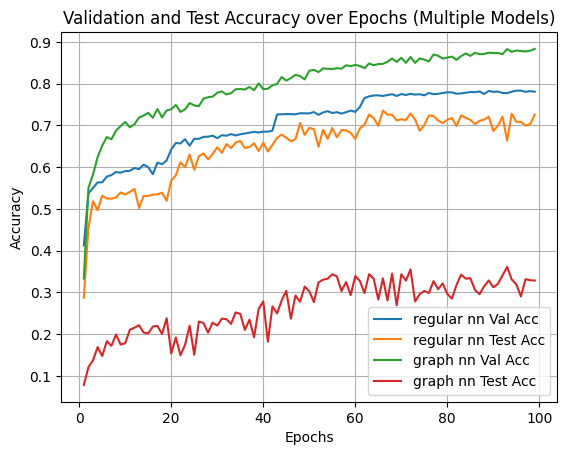

In [3]:
import matplotlib.pylab as plt

data = []
tables = [nn_data,graph_nn]
for label, table in tables:
    temp = {"label": label, "epochs": [], "val_acc": [], "test_acc": []}
    for line in table:
        line = list(map(lambda x: float(x.split(":")[1].strip()),line.split(",")))
        temp["epochs"].append(line[0])
        temp["val_acc"].append(line[1])
        temp["test_acc"].append(line[2])
    data.append(temp)

# Create plot
for model_data in data:
    plt.plot(model_data['epochs'], model_data['val_acc'], label=f"{model_data['label']} Val Acc")
    plt.plot(model_data['epochs'], model_data['test_acc'], label=f"{model_data['label']} Test Acc")

# Labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation and Test Accuracy over Epochs (Multiple Models)')

# Show legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()